# Logistic Regression for Amazon fine food reviews for Bag of words, tf-idf, average word2vec and tf-idf weighted word2vec

### The objective

Given a text review, we have to predict whether the review represents positove sentiment or negative.
In other words, we ahve to classify the review as 'Positive' or 'Negative'.
We will use the Amazon fine food review dataset from Kaggle.com

https://www.kaggle.com/snap/amazon-fine-food-reviews
    
### Context

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Contents

    Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
    database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews    

#### SGDClassifier:
SGDclassifier with log loss gives logistic regression with stochastic gradient descent.
It is useful for big datasets due to the stochastic gradient descent implementation 

We will use SGDclassifier with loss='log' for logistic regression on our dataset.

First, import all required libraries


In [ ]:
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
import parfit.parfit as pf
import sqlite3
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
#from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')
import gensim

In [2]:

import pickle
def load_from_file(file_name):
    
    with open(file_name, 'rb') as filehandle:  
        # read the data as binary data stream
        list1 = pickle.load(filehandle)
        return list1
    
def dump_to_file(data,file_name):
    with open(file_name, 'wb') as filehandle:  
        # store the data as binary data stream
        pickle.dump(data, filehandle)


#### Function to print confusion matrix and classification report

In [3]:
from prettytable import PrettyTable
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,6), fontsize=10):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
def print_classif_report(input_dict):
    tab = PrettyTable()
    tab.field_names = ["Label","Precision","Recall","f1-Score","Support"]
    list1=[]
    for k,v in input_dict.items():
        list1=[]
        list1.append(k)
        for i,j in v.items():
            list1.append("{0:.2f}".format(j))
        
        tab.add_row(list1)
    print(tab)    

#### function to get important features for given classifier and vectorizer

In [4]:

def most_informative_feature(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names),reverse=True)[:n]

    print('Negative class')
    
    
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print(' ************************************* ')
    print('Positive class')
    
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)


#### function to plot RoC curve

In [5]:
def plot_roc_curve(actual,pred):
    fpr,tpr,threholds = roc_curve(actual,pred[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC : {}'.format(auc(fpr,tpr)))
    plt.show()

### Read the data from SQLite file

Read the data from database.
We will not consider 3 star reviews as they are neutral (neither completely positive nor negative)

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 as they are neutral

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

Check sample data

In [7]:
filtered_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


Sort the data by productid

In [7]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Remove duplicates

In [8]:
#Remove duplicate reviews by same user at same time
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Remove rows where helpfulness denominator is greater than helpfulness numerator

In [9]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

Function to clean the sentences.
The function will remove html tags and punctuation marks from the input text and return cleaned text.

In [53]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/|-|+|;|&]',r' ',cleantext)
    return  cleantext


Sort by time for time based splitting

In [11]:
sample=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Cleaning the review text by using above written function.
Also performing the stemming procedure to reduce the words to their base stem forms.
Cleaned text will be stored in separate column.
For tf-idf weighted word2vec, we are storing non-stemmed clean review text in another column.

In [12]:
i=0
str1=' '
str2=' '
final_string=[]
final_string_2=[]
s=''
s1=''
for sent in sample['Text'].values:
    filtered_sentence=[]
    filtered_nostem = []
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    s1 = (w.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    filtered_nostem.append(s1)
                    
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    str2 = b" ".join(filtered_nostem) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    final_string_2.append(str2)
    i+=1

In [13]:
#adding a column  which displays the data after pre-processing of the review 
sample['CleanedText']=final_string
sample['CleanedTextNoStem']=final_string_2

Save the cleaned text in a file for use later

In [14]:
#pickle.dump(sample,open('cleaned_final.p','wb'))
pd.to_pickle(sample,'cleaned_Text.pkl')

In [6]:
loaddf=pd.read_pickle('cleaned_Text.pkl')

In [7]:
sample=loaddf

In [8]:
#sample.head(1)
sample.head(1)
#sample['Score'].value_counts()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedTextNoStem
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...


### First using Bag of Words vectorizer

In [9]:
#sort by time for time based splitting
sample=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
from sklearn.model_selection import train_test_split

X_tr, x_test, Y_tr, y_test = train_test_split(sample['CleanedText'].values,sample['Score'].values,test_size=0.2,shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(X_tr,Y_tr,test_size=0.2,shuffle=False)


In [11]:
## to prevent WRITEBACKIFCOPY read only error for sparse matrices for parallel fit library
## source:- https://github.com/scikit-learn/scikit-learn/issues/6614

class MyCountVectorizer(CountVectorizer):
    def fit_transform(self,x):
        res = super(MyCountVectorizer,self).fit_transform(x)
        res.sort_indices()
        return res

#### perform vectorization and store the result into disk for later use.
To avoid data leakage, we fit_transform train set and apply same vectorizer to validation and Test set

In [28]:
count_vect = MyCountVectorizer(ngram_range=(1,2),min_df=50)
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_val =  count_vect.transform(x_val)
bag_of_words_test =  count_vect.transform(x_test)

import scipy.sparse
scipy.sparse.save_npz('bag_of_words_train', bag_of_words_train)
scipy.sparse.save_npz('bag_of_words_val', bag_of_words_val)
scipy.sparse.save_npz('bag_of_words_test', bag_of_words_test)

In [29]:
bag_of_words_val=scipy.sparse.load_npz('bag_of_words_val.npz')
bag_of_words_test=scipy.sparse.load_npz('bag_of_words_test.npz')
bag_of_words_train=scipy.sparse.load_npz('bag_of_words_train.npz')

#### We use the Parfit library to fit and check the score for all combination of parameters alpha and penalty using simple validation set.

Parfit is a new library for parallel fitting of models to check for optimal hyperparameters.
It uses all processors for the fitting and scoring.
It returns best model and best score as well as all models and their scores.

More information on Parfit :-
https://github.com/jmcarpenter2/parfit

Source code reference for logistic regression using SGDclassifier for big datasets: 
https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  3.3min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  4.8min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  5.4min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  6.4min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  7.8min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  7.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  9.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.2s finished


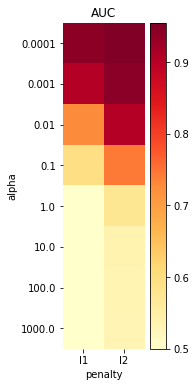

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.9550937386409861
Wall time: 9min 14s


In [35]:
%%time

grid = {'alpha':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
       'max_iter':[1000],
       'loss':['log'],
        'n_jobs':[-1],
       'penalty':['l1','l2']}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier,paramGrid,bag_of_words_train,y_train,bag_of_words_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModel,bestScore)

#### most important features for each class

In [36]:
most_informative_feature(count_vect,bestModel)

Negative class
0 -1.8666348040736591 worst
0 -1.5279830495489357 two star
0 -1.4591783352890546 disappoint
0 -1.4388520388676904 aw
0 -1.4224329920857106 terribl
0 -1.3226868349198695 horribl
0 -1.2620055076793335 wont buy
0 -1.1981904646084438 threw
0 -1.142253152438983 never buy
0 -1.1294180104928684 tasteless
 ************************************* 
Positive class
1 1.6001783506267604 high recommend
1 1.4686732997671614 delici
1 1.3482944219992556 wont disappoint
1 1.2652546451423645 excel
1 1.185735680251847 perfect
1 1.1449520275757454 amaz
1 1.0659230391428955 best
1 1.044068180892728 awesom
1 1.0379944195899669 addict
1 1.035103725137934 hook


#### model performance on test data

AUC score: 0.95
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.86   |  0.66  |   0.75   | 12535.00 |
|      1       |    0.93   |  0.98  |   0.95   | 60300.00 |
|  micro avg   |    0.92   |  0.92  |   0.92   | 72835.00 |
|  macro avg   |    0.90   |  0.82  |   0.85   | 72835.00 |
| weighted avg |    0.92   |  0.92  |   0.92   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


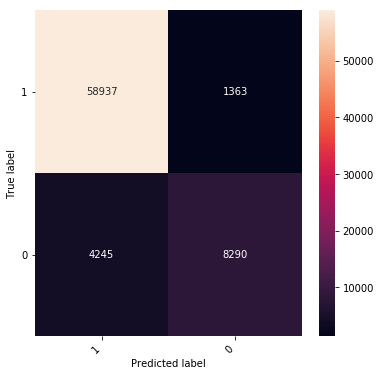

In [38]:

predicted = bestModel.predict(bag_of_words_test)
bow_score = roc_auc_score(y_test,bestModel.predict_proba(bag_of_words_test)[:,1])
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



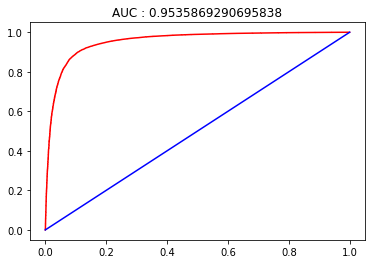

In [39]:
plot_roc_curve(y_test,bestModel.predict_proba(bag_of_words_test))

#### Logistic regression for TF-IDF vectorization

In [28]:
## to prevent WRITEBACKIFCOPY read only error for sparse matrices for parallel fit library
## source:- https://github.com/scikit-learn/scikit-learn/issues/6614

class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self,x):
        res = super(MyTfidfVectorizer,self).fit_transform(x)
        res.sort_indices()
        return res

#### Fit transform on the train data and transform the validation and test set using same vectorizer.
Store the vectorized train,validation and test set for later use.

In [41]:
tfidf_vect = MyTfidfVectorizer(ngram_range=(1,2),min_df=50)
tfidf_train = tfidf_vect.fit_transform(x_train)
tfidf_val =  tfidf_vect.transform(x_val)
tfidf_test =  tfidf_vect.transform(x_test)

import scipy.sparse
scipy.sparse.save_npz('tfidf_train', tfidf_train)
scipy.sparse.save_npz('tfidf_val', tfidf_val)
scipy.sparse.save_npz('tfidf_test', tfidf_test)

In [42]:
tfidf_train=scipy.sparse.load_npz('tfidf_train.npz')
tfidf_val=scipy.sparse.load_npz('tfidf_val.npz')
tfidf_test=scipy.sparse.load_npz('tfidf_test.npz')

#### Using Parfit to find optimal parameters using SGDclassifier for logistic regression

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  3.2min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  4.6min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  4.9min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  6.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  7.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  7.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  8.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished


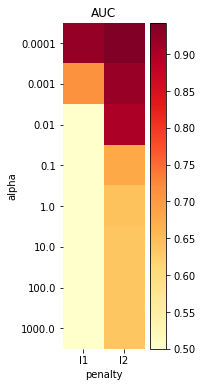

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.942748522885138
Wall time: 8min 55s


In [43]:
%%time

grid = {'alpha':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
       'max_iter':[1000],
       'loss':['log'],
        'n_jobs':[-1],
       'penalty':['l1','l2']}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier,paramGrid,tfidf_train,y_train,tfidf_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModel,bestScore)

#### Most important features for each class

In [46]:
most_informative_feature(tfidf_vect,bestModel)

Negative class
0 -5.482483591634366 disappoint
0 -3.2913901278553372 bad
0 -3.2208005523074994 return
0 -3.0568519188822854 worst
0 -2.9440286030997895 money
0 -2.8830091149288157 aw
0 -2.8606806105888305 terribl
0 -2.8097845655504994 tast
0 -2.7815091349058663 horribl
0 -2.681193461751771 wast
 ************************************* 
Positive class
1 6.290730388777367 great
1 5.185785413399291 love
1 4.431519045025835 best
1 3.7984561117882567 delici
1 3.279593508502295 good
1 3.188080822960566 perfect
1 2.8030457789554712 excel
1 2.6357735027868854 nice
1 2.619228042071929 favorit
1 2.3021618771956827 easi


#### evaluate the best model on the test set

AUC score: 0.94
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.94   |  0.29  |   0.45   | 12535.00 |
|      1       |    0.87   |  1.00  |   0.93   | 60300.00 |
|  micro avg   |    0.87   |  0.87  |   0.87   | 72835.00 |
|  macro avg   |    0.91   |  0.64  |   0.69   | 72835.00 |
| weighted avg |    0.88   |  0.87  |   0.85   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


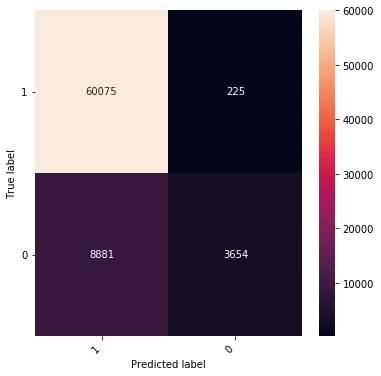

In [47]:

predicted = bestModel.predict(tfidf_test)
tfidf_score = roc_auc_score(y_test,bestModel.predict_proba(tfidf_test)[:,1])
print('AUC score:',round(tfidf_score,2))
print('Classification report  :-')
tfidf_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(tfidf_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



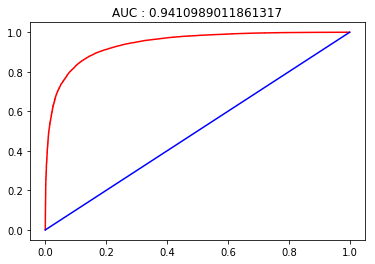

In [48]:
plot_roc_curve(y_test,bestModel.predict_proba(tfidf_test))

#### Using average word2vec vectorization

In [69]:
# Prepare list of sentences for average word2vec

from nltk.tokenize import word_tokenize

train_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[:233068]]]
val_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[233068:291336]]]
test_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[291336:]]]


#### store to disk for later use

In [70]:
dump_to_file(train_list,'train_list.data')
dump_to_file(val_list,'val_list.data')
dump_to_file(test_list,'test_list.data')

In [11]:
train_list = load_from_file('train_list.data')
val_list = load_from_file('val_list.data')
test_list = load_from_file('test_list.data')

#### build vocabulary on the train set

In [12]:
w2v_model = gensim.models.Word2Vec(train_list,min_count=50,size=300)

In [13]:
print(w2v_model.most_similar('good'))
print('******************************************************************************')
print(w2v_model.most_similar('bad'))

[('great', 0.7035960555076599), ('decent', 0.6836462020874023), ('awesome', 0.6074135303497314), ('terrific', 0.5886241793632507), ('fantastic', 0.5740854740142822), ('excellent', 0.567488431930542), ('bad', 0.5258399248123169), ('yummy', 0.5229069590568542), ('incredible', 0.5213609933853149), ('nice', 0.4884307086467743)]
******************************************************************************
[('terrible', 0.6002316474914551), ('awful', 0.5648783445358276), ('horrible', 0.5519883632659912), ('gross', 0.5389324426651001), ('weird', 0.5356461405754089), ('funny', 0.5281544923782349), ('good', 0.5258398652076721), ('nasty', 0.5004900693893433), ('disgusting', 0.48209506273269653), ('okay', 0.47481223940849304)]


#### vectorize train set

In [14]:
avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    avg_wt_vecs.append(sent_vec) #append to list of sentence vectors 

In [15]:
print(np.isfinite(avg_wt_vecs).all())
print(np.isnan(avg_wt_vecs).any())

True
False


#### Vectorize validation set

In [16]:
val_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list

for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if (cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    val_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

In [17]:
print(np.isfinite(val_avg_wt_vecs).all())
print(np.isnan(val_avg_wt_vecs).any())

True
False


#### vectorize test set

In [18]:
test_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    test_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

In [19]:
print(np.isfinite(test_avg_wt_vecs).all())
print(np.isnan(test_avg_wt_vecs).any())

True
False


#### Store to disk for later use

In [20]:
X_tr = avg_wt_vecs
X_test = test_avg_wt_vecs
X_val = val_avg_wt_vecs
print(len(X_tr))
print(len(X_val))
print(len(X_test))

dump_to_file(avg_wt_vecs,'avg_wt_vecs_train.data')
dump_to_file(val_avg_wt_vecs,'val_avg_wt_vecs.data')
dump_to_file(test_avg_wt_vecs,'test_avg_wt_vecs.data')
avg_wt_vecs=load_from_file('avg_wt_vecs_train.data')
val_avg_wt_vecs=load_from_file('val_avg_wt_vecs.data')
test_avg_wt_vecs=load_from_file('test_avg_wt_vecs.data')

233068
58268
72835


#### Scale and use parfit to find best model using simple validation set.

In [22]:
scaler=StandardScaler()
X_tr=scaler.fit_transform(X_tr)
X_val=scaler.fit_transform(X_val)
X_test=scaler.fit_transform(X_test)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  8.5min remaining: 36.9min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed: 16.8min remaining: 36.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed: 19.9min remaining: 25.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed: 24.6min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 26.1min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 30.9min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 40.2min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.4s finished


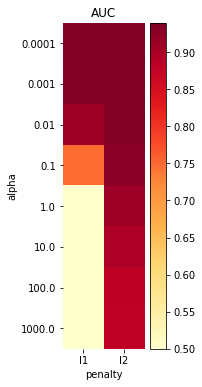

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.9397173893407327
Wall time: 40min 13s


In [23]:
%%time

grid = {'alpha':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
       'max_iter':[1000],
       'loss':['log'],
        'n_jobs':[-1],
       'penalty':['l1','l2']}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier,paramGrid,X_tr,y_train,X_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModel,bestScore)

#### Evaluate the best model on the Test set

AUC score: 0.94
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.82   |  0.60  |   0.69   | 12535.00 |
|      1       |    0.92   |  0.97  |   0.95   | 60300.00 |
|  micro avg   |    0.91   |  0.91  |   0.91   | 72835.00 |
|  macro avg   |    0.87   |  0.79  |   0.82   | 72835.00 |
| weighted avg |    0.90   |  0.91  |   0.90   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


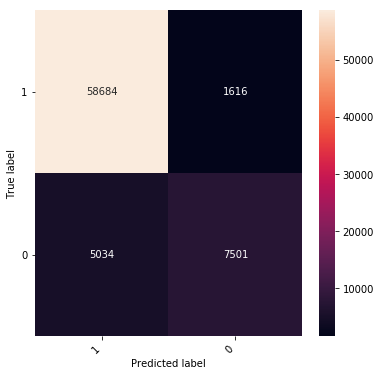

In [24]:

predicted = bestModel.predict(X_test)
avg_w2v_score = roc_auc_score(y_test,bestModel.predict_proba(X_test)[:,1])
print('AUC score:',round(avg_w2v_score,2))
print('Classification report  :-')
avg_w2v_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(avg_w2v_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



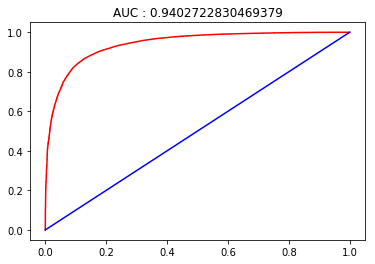

In [25]:
plot_roc_curve(y_test,bestModel.predict_proba(X_test))

#### Using TF-IDF weighted word2vec vectorization

In [26]:
X_tr1, X_test, y_tr1, y_test = train_test_split(sample['CleanedTextNoStem'].values, sample['Score'].values, test_size=0.2,shuffle=False)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr1, y_tr1, test_size=0.2,shuffle=False)

#### Store the tf-idf on unstemmed data in a dictionary for better performance

In [29]:
tfidf_vect = MyTfidfVectorizer(ngram_range=(1,2),min_df=50)
tfidf_train = tfidf_vect.fit_transform(X_tr)

tfidf_test =  tfidf_vect.transform(X_test) #use same vectorizer to transform test instances
tfidf_val =  tfidf_vect.transform(X_val) #use same vectorizer to transform test instances

features = tfidf_vect.get_feature_names()
#len(features)
dict_feature={}
idx=0
for feature in features:
    dict_feature[feature]=idx
    idx += 1
#len(features)

#### Vectorize the train data set

In [30]:
index = 0
tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in train_list: # for each review/sentence
    
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if sum_tfidf != 0:
            sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    
       
    tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    
    index += 1
    

In [31]:
print(np.isfinite(tfidf_wt_vecs).all())
print(np.isnan(tfidf_wt_vecs).any())

True
False


#### Vectorize the Validation set

In [32]:
index = 0
val_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_val[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    val_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [33]:
print(np.isfinite(val_tfidf_wt_vecs).all())
print(np.isnan(val_tfidf_wt_vecs).any())

True
False


#### Vectorize the test data set

In [34]:
index = 0
test_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    test_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [35]:
print(np.isfinite(test_tfidf_wt_vecs).all())
print(np.isnan(test_tfidf_wt_vecs).any())

True
False


#### Store the vectors in disk for later use.

In [36]:
X_tr = tfidf_wt_vecs
X_test = test_tfidf_wt_vecs
X_val = val_tfidf_wt_vecs

In [37]:
dump_to_file(test_tfidf_wt_vecs,'test_tfidf_wt_vecs.data')
dump_to_file(tfidf_wt_vecs,'tfidf_wt_vecs.data')
dump_to_file(val_tfidf_wt_vecs,'val_tfidf_wt_vecs.data')
tfidf_wt_vecs = load_from_file('tfidf_wt_vecs.data')
val_tfidf_wt_vecs = load_from_file('val_tfidf_wt_vecs.data')
test_tfidf_wt_vecs = load_from_file('test_tfidf_wt_vecs.data')

#### Scale and use parfit to find best model

In [38]:
scaler=StandardScaler()
X_tr=scaler.fit_transform(X_tr)
X_val=scaler.fit_transform(X_val)
X_test=scaler.fit_transform(X_test)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  8.4min remaining: 36.3min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed: 16.6min remaining: 36.4min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed: 18.7min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed: 24.8min remaining: 19.3min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 25.8min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 30.8min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 38.8min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.6s finished


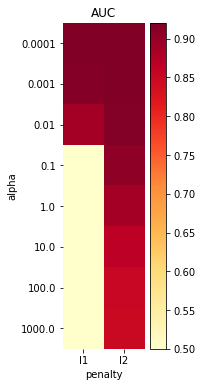

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.9206855344415696
Wall time: 38min 51s


In [39]:
%%time

grid = {'alpha':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
       'max_iter':[1000],
       'loss':['log'],
        'n_jobs':[-1],
       'penalty':['l1','l2']}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier,paramGrid,X_tr,y_train,X_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModel,bestScore)

#### Evaluate the best model on test set

AUC score: 0.92
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.80   |  0.51  |   0.63   | 12535.00 |
|      1       |    0.91   |  0.97  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.85   |  0.74  |   0.78   | 72835.00 |
| weighted avg |    0.89   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


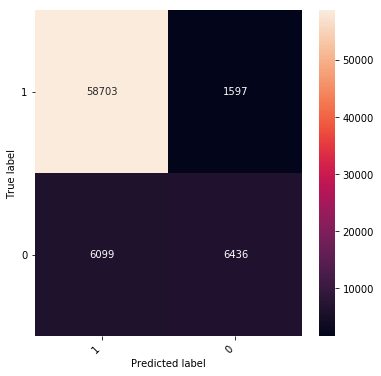

In [40]:

predicted = bestModel.predict(X_test)
tfidf_w2v_score = roc_auc_score(y_test,bestModel.predict_proba(X_test)[:,1])
print('AUC score:',round(tfidf_w2v_score,2))
print('Classification report  :-')
tfidf_w2v_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(tfidf_w2v_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



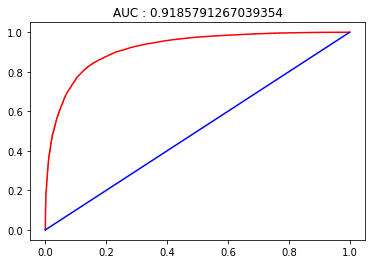

In [41]:
plot_roc_curve(y_test,bestModel.predict_proba(X_test))

#### Summary

In [5]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.field_names = ["Vectorizer","Alpha","Penalty","AUC"]
list1=["BOW bigram","0.0001","L2","0.95"]
list2=["TFIDF bigram","0.0001","L2","0.94"]
list3=["Avg w2v","0.0001","L2","0.94"]
list4=["TFIDF w2v","0.0001","L2","0.92"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+--------------+--------+---------+------+
|  Vectorizer  | Alpha  | Penalty | AUC  |
+--------------+--------+---------+------+
|  BOW bigram  | 0.0001 |    L2   | 0.95 |
| TFIDF bigram | 0.0001 |    L2   | 0.94 |
|   Avg w2v    | 0.0001 |    L2   | 0.94 |
|  TFIDF w2v   | 0.0001 |    L2   | 0.92 |
+--------------+--------+---------+------+
